# Vorlesung 9: Gruppenvergleiche

### Set-Up

In [1]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version


path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

/Users/karlaruggaber/.pyenv/versions/3.10.6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Anzahl Zeilen: 1296675
Anzahl Spalten: 24


### Gruppenvergleiche der Transaktionskategorien im Bezug auf den Transaktionsbetrag


#### Fragestellung: Unterscheidet sich der durchschnittliche Transaktionsbetrag in den unterschiedlichen Transaktionskategorien?

Nullhypothese $H_0$ : $μ_{\text{1. Kategorie}}$ = $μ_{\text{2. Kategorie}}$ = ... = $μ_{\text{k. Kategorie}} \ \forall k = \text{Transaktionskategorien}$ (Die Mittelwerte der Transaktionsbetr$ge sind gleich in allen Transaktionskategorien).

Alternativhypothese $H_1$: $μ_{\text{i. Kategorie}} \neq μ_{\text{j. Kategorie}} \ \text{für} \ \ i \neq j, \ i,j \in \{Transaktionskategorien\}$ (Transaktionskategorien haben unterschiedliche Transaktionsbetragsmittelwerte).

Der Code berechnet für jede Transaktionskategorie die Schiefe (Skewness) der Betragsverteilung (amt), also wie stark die Werte asymmetrisch verteilt sind, und sortiert die Kategorien nach dieser Schiefe absteigend.

In [2]:
from scipy.stats import skew

skewness_ds = (
    ds.groupby("category")["amt"]
    .apply(lambda x: skew(x, bias=False))
    .reset_index(name="skewness")
    .sort_values("skewness", ascending=False)
)

print(skewness_ds)

          category  skewness
13          travel   20.7990
12    shopping_pos    8.8350
11    shopping_net    8.1642
9         misc_pos    5.3916
8         misc_net    4.1726
0    entertainment    2.7337
10   personal_care    2.0818
1      food_dining    2.0477
5   health_fitness    1.8546
7        kids_pets    1.8077
6             home    1.7355
4      grocery_pos    1.1245
3      grocery_net    0.6986
2    gas_transport    0.2464


Da mind. eine Gruppe (hier eine Kategorie) starke Schiefe zeigt (z.b. die Kategorie "Travel"), ist ANOVA ungeeignet und sogar unzuverlässig, weshalb wir Kruskal-Wallis verwenden.

In [3]:
from scipy.stats import kruskal

groups = [g["amt"].values for _, g in ds.groupby("category")]

stat, p = kruskal(*groups)

print("Kruskal-Wallis Test")
print("Statistic:", stat)
print("p-value :", p)

Kruskal-Wallis Test
Statistic: 262024.5463747941
p-value : 0.0


Der folgende Code visualisiert den Unterschied zwischen Rohwerten der Transaktionsbeträge und deren Rängen, um das Prinzip des Kruskal-Wallis-Tests anschaulich zu machen. Links werden die stark schief verteilten Beträge pro Kategorie dargestellt, während rechts dieselben Daten als globale Ränge geplottet sind, wodurch die Verteilungen vergleichbarer werden und Ausreißer weniger Einfluss haben.

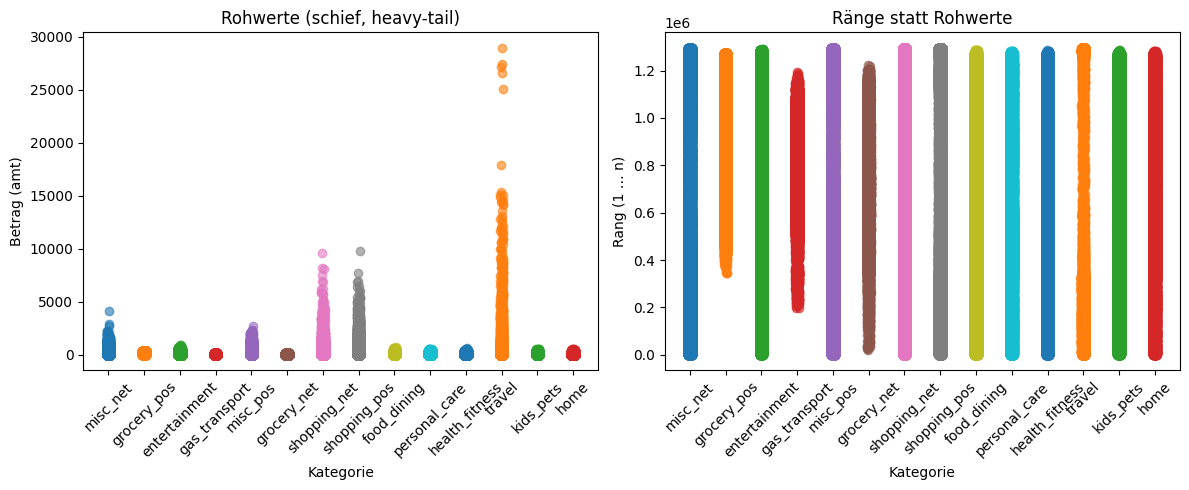

In [25]:
cats = ds['category'].unique()
ds_plot = ds.copy()

# Ränge (global über alle Beobachtungen – wie bei Kruskal)
ds_plot['rank'] = ds_plot['amt'].rank(method='average')

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Links: Rohwerte (schief, heavy-tail)
axes[0].set_title("Rohwerte (schief, heavy-tail)")
for i, cat in enumerate(cats):
    y = ds_plot.loc[ds_plot['category'] == cat, 'amt']
    x = np.full_like(y, i, dtype=float) + (np.random.rand(len(y)) - 0.5)*0.1
    axes[0].scatter(x, y, alpha=0.6, label=cat)
axes[0].set_xticks(range(len(cats)))
axes[0].set_xticklabels(cats, rotation=45)
axes[0].set_xlabel("Kategorie")
axes[0].set_ylabel("Betrag (amt)")

# Rechts: Ränge statt Rohwerte
axes[1].set_title("Ränge statt Rohwerte")
for i, cat in enumerate(cats):
    y = ds_plot.loc[ds_plot['category'] == cat, 'rank']
    x = np.full_like(y, i, dtype=float) + (np.random.rand(len(y)) - 0.5)*0.1
    axes[1].scatter(x, y, alpha=0.6, label=cat)
axes[1].set_xticks(range(len(cats)))
axes[1].set_xticklabels(cats, rotation=45)
axes[1].set_xlabel("Kategorie")
axes[1].set_ylabel("Rang (1 … n)")

plt.tight_layout()
plt.show()

Da der p-value extrem klein ist, können wir die Nullhypothese verwerfen ($H_0$: Alle Kategorien haben die gleiche Verteilung des Transaktionsbetrags). Es gibt also Kategorien, deren Transaktionsbeträge systematisch unterschiedlich sind.

Im folgenden Code wird ein Dunn-Post-hoc-Test durchgeführt, um nun zu untersuchen, welche Transaktionskategorien sich konkret hinsichtlich des Transaktionsbetrags unterscheiden, da Kruskal-Wallis nur zeigt dass es einen Unterschied gibt, aber nicht wo dieser liegt. Dabei werden alle Kategorien paarweise verglichen und als Ergebnis eine Matrix von p-Werten ausgegeben, wobei kleine p-Werte auf signifikante Unterschiede zwischen zwei Kategorien hinweisen und keine Korrektur für multiples Testen vorgenommen wird.

In [4]:
import scikit_posthocs as sp
raw_dunn = sp.posthoc_dunn(
    ds,
    val_col='amt',
    group_col='category',
    p_adjust=None
)
raw_dunn

,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
entertainment,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2618,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
food_dining,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
gas_transport,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
grocery_net,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
grocery_pos,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
health_fitness,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
home,0.2618,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
kids_pets,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
misc_net,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
misc_pos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000


Da wir sehr viele unkorrigierte p-values haben (sehr viele p-values fast gleich Null), benutzen wir nun FDR-Korrektur

In [5]:
from statsmodels.stats.multitest import multipletests

# Extrahieren der p-Werte des oberen Dreiecks
pvals = raw_dunn.values[np.triu_indices_from(raw_dunn, k=1)]

#  FDR-Korrektur anwenden
reject, pvals_corrected, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="fdr_bh"
)

# Korrigierte p-Wert-Matrix rekonstruieren
categories = raw_dunn.columns
corr_matrix = pd.DataFrame(
    np.zeros_like(raw_dunn, dtype=float),
    index=categories,
    columns=categories
)

idx = 0
for i in range(len(categories)):
    for j in range(i + 1, len(categories)):
        corr_matrix.iloc[i, j] = pvals_corrected[idx]
        corr_matrix.iloc[j, i] = pvals_corrected[idx]
        idx += 1

corr_matrix

,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
entertainment,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2618,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
food_dining,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
gas_transport,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
grocery_net,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
grocery_pos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
health_fitness,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
home,0.2618,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
kids_pets,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
misc_net,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
misc_pos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Bis auf die Kategorien Entertainment vs Home unterscheiden sich alle Kategorien signifikant von einander

Die Analyse zeigt deutlich, dass sich die Transaktionsbeträge zwischen nahezu allen Kategorien signifikant unterscheiden. Aufgrund der starken Schiefe der Verteilungen war eine nichtparametrische Vorgehensweise erforderlich. Der Kruskal-Wallis-Test ergab einen hochsignifikanten Gesamteffekt, was auf systematische Unterschiede zwischen den Gruppen hinweist. Die anschließenden Dunn-Post-hoc-Tests mit FDR-Korrektur bestätigten, dass fast alle Kategorien paarweise unterschiedliche Ausgabenniveaus aufweisen. Lediglich die Kategorien Entertainment und Home zeigten keinen signifikanten Unterschied. Insgesamt verdeutlichen die Ergebnisse, dass die Art der Transaktion einen klaren Einfluss auf die Höhe der getätigten Beträge hat, was inhaltlich gut mit den typischen Ausgabemustern dieser Kategorien übereinstimmt.

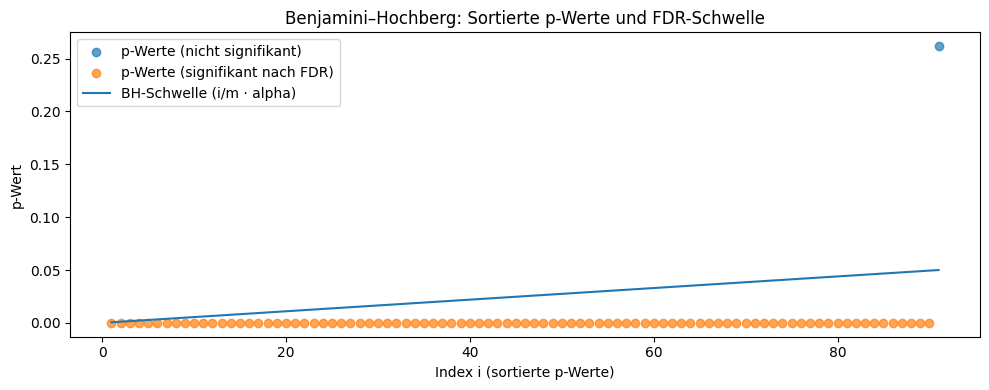

In [7]:
# p-Werte aus oberem Dreieck der Matrix
pvals = raw_dunn.values[np.triu_indices_from(raw_dunn, k=1)]

# Sortieren
p_sorted = np.sort(pvals)
m = len(p_sorted)
alpha = 0.05
bh_thresholds = (np.arange(1, m+1) / m) * alpha

# signifikante nach BH herausfinden
significant = p_sorted <= bh_thresholds

plt.figure(figsize=(10, 4))
x = np.arange(1, m+1)

# nicht signifikant
plt.scatter(x[~significant], p_sorted[~significant], label="p-Werte (nicht signifikant)", alpha=0.7)
# signifikant
plt.scatter(x[significant], p_sorted[significant], label="p-Werte (signifikant nach FDR)", alpha=0.7)

# BH-Schwelle
plt.plot(x, bh_thresholds, label="BH-Schwelle (i/m · alpha)")

plt.xlabel("Index i (sortierte p-Werte)")
plt.ylabel("p-Wert")
plt.title("Benjamini–Hochberg: Sortierte p-Werte und FDR-Schwelle")
plt.legend()
plt.tight_layout()
plt.show()

Der obige Code erzeugt eine Visualisierung der False Discovery Rate (FDR) nach dem Benjamini–Hochberg-Verfahren. Er zeigt die sortierten p-Werte der paarweisen Kategorienvergleiche im Verhältnis zur BH-Schwelle, sodass man grafisch erkennen kann, welche Tests unter Kontrolle der FDR als signifikant gelten und wo die Grenze zwischen signifikant und nicht signifikant verläuft.

Der folgende Code visualisiert die FDR-korrigierten p-Werte des Dunn-Post-hoc-Tests zusätzlich noch als Heatmap, wobei jede Zelle den Signifikanzgrad eines Kategorienpaars darstellt. Durch die Begrenzung der Farbskala auf kleine p-Werte (0–0,05) werden signifikante Unterschiede zwischen Kategorien auf einen Blick sichtbar, während nicht signifikante Vergleiche ausgeblendet bzw. farblich neutralisiert werden.

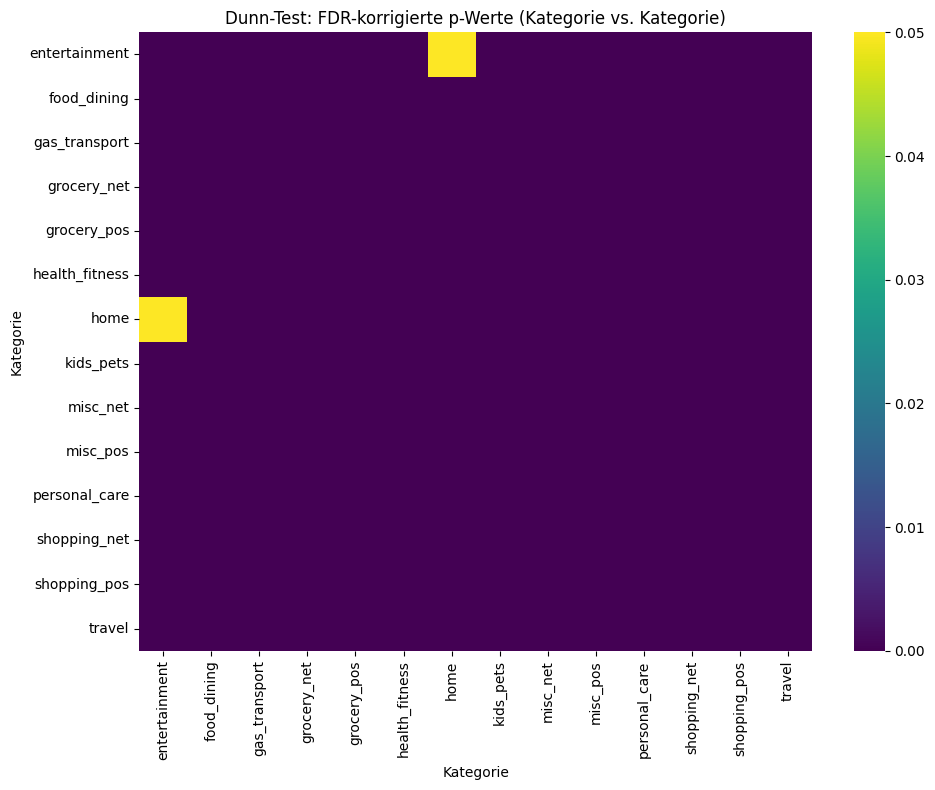

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="viridis", vmin=0, vmax=0.05)
plt.title("Dunn-Test: FDR-korrigierte p-Werte (Kategorie vs. Kategorie)")
plt.xlabel("Kategorie")
plt.ylabel("Kategorie")
plt.tight_layout()
plt.show()

Erkenntnis:
Die Heatmap zeigt, dass nach FDR-Korrektur nur sehr wenige Kategorienpaare signifikante Unterschiede im Transaktionsbetrag aufweisen, während der Großteil der Vergleiche keine statistisch relevanten Differenzen zeigt. Damit wird deutlich, dass sich die meisten Kategorien hinsichtlich ihrer Betragsverteilungen ähneln und die wenigen signifikanten Unterschiede robust sind und nicht durch multiples Testen künstlich entstanden sind.

Der folgende Code führt paarweise Vergleiche aller Transaktionskategorien durch, indem er zu jedem Kategorienpaar statistische Signifikanz und Effektstärke kombiniert auswertet. Für jedes Paar werden die FDR-korrigierten p-Werte, die Mittelwertdifferenz der Transaktionsbeträge sowie Cliff’s Delta inklusive Effektstärkekategorie berechnet und in einer übersichtlichen Tabelle zusammengeführt, die nach der Stärke des Effekts sortiert ist.

Cliff’s Delta ist ein nichtparametrisches Maß für die Effektstärke, das angibt, wie stark sich zwei Gruppen voneinander unterscheiden, ohne Verteilungsannahmen zu machen. Es misst, wie häufig Werte aus einer Gruppe größer sind als Werte aus einer anderen, und liegt zwischen −1 und +1, wobei 0 keinen Unterschied bedeutet und der Betrag die Stärke des Effekts (vernachlässigbar, klein, mittel, groß) beschreibt. Es ist äquivalent zur Effektstärke Cohen's D, welche wir in der Vorlesung gesehen haben.

In [9]:
from cliffs_delta import cliffs_delta

# Mittelwerte je Kategorie
cat_means = ds.groupby("category")["amt"].mean()

# Alle Paarvergleiche sammeln
rows = []

groups = corr_matrix.index.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1 = groups[i]
        g2 = groups[j]

        # FDR-korrigierter p-Wert
        p = corr_matrix.loc[g1, g2]

        # Daten
        x = ds[ds["category"] == g1]["amt"]
        y = ds[ds["category"] == g2]["amt"]

        # Mittelwerte
        m1 = cat_means[g1]
        m2 = cat_means[g2]
        diff = m2 - m1

        # Cliff's Delta
        delta, size = cliffs_delta(x, y)
        # size ist bereits: 'negligible', 'small', 'medium', 'large'

        # abs(delta) für Sortierung später
        rows.append({
            "Kategorie 1": g1,
            "Kategorie 2": g2,
            "MW Kat 1": m1,
            "MW Kat 2": m2,
            "Diff (K2 - K1)": diff,
            "p-Wert (FDR)": p,
            "Cliff's Delta": delta,
            "Effekt-Kategorie": size
        })

# DataFrame bauen
cat_compare_cliff = pd.DataFrame(rows)

# p-Werte schöner anzeigen
cat_compare_cliff["p-Wert (FDR)"] = cat_compare_cliff["p-Wert (FDR)"].apply(lambda x: format(x, ".12e"))

# Sortiert nach |Delta|
cat_compare_cliff = cat_compare_cliff.reindex(cat_compare_cliff["Cliff's Delta"].abs().sort_values().index)

# Anzeige zurücksetzen, damit nicht alle Zeilen gezeigt werden
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.expand_frame_repr")

cat_compare_cliff

,Kategorie 1,Kategorie 2,MW Kat 1,MW Kat 2,Diff (K2 - K1),p-Wert (FDR),Cliff's Delta,Effekt-Kategorie
5,entertainment,home,64.2104,58.2701,-5.9403,2.617679729748e-01,-0.0020,negligible
76,misc_net,misc_pos,80.8651,62.8910,-17.9741,2.232421291067e-63,0.0071,negligible
6,entertainment,kids_pets,64.2104,57.5369,-6.6736,1.572868811790e-07,0.0144,negligible
63,home,kids_pets,58.2701,57.5369,-0.7333,1.074498067138e-11,0.0145,negligible
2,entertainment,grocery_net,64.2104,53.6701,-10.5403,6.856501037632e-22,-0.0345,negligible
...,...,...,...,...,...,...,...,...
35,gas_transport,travel,63.4346,111.5047,48.0701,0.000000000000e+00,0.7196,large
26,gas_transport,grocery_pos,63.4346,116.9610,53.5264,0.000000000000e+00,-0.7207,large
51,grocery_pos,personal_care,116.9610,47.9677,-68.9933,0.000000000000e+00,0.7274,large
54,grocery_pos,travel,116.9610,111.5047,-5.4563,0.000000000000e+00,0.7283,large


Wie man erkennen kann, sind die p-Werte überall extrem klein. Das heisst aber nicht automatisch, dass auch überall tatsächlich ein Effekt vorhanden ist. Die letzte Spalte (die Übersetzung von Cliff's Delta in eine Effektkategorie) zeigt hier genau, ob auch wirklich ein tatsächlicher Effekt vorhanden ist. Wenn man die letzten paar Spalten betrachtet, fällt auf, dass so gut wie immer die Kategorie *grocery_pos* involviert ist. Wenn man nun die Mittelwerte betrachtet, sieht man, dass der Mittelwert der Lebensmitteleinkäufe vor Ort stark variiert zu anderen Mittelwerten.

### Gruppenvergleiche von Altersgruppen mit Bezug auf den Transaktionsbetrag


#### Fragestellung: Unterscheidet sich der durchschnittliche Transaktionsbetrag in unterschiedlichen Altersgruppen?

Nullhypothese $H_0$ : $μ_{\text{1. Altersgruppe}}$ = $μ_{\text{2. Altersgruppe}}$ = ... = $μ_{\text{k. Altersgruppe}} \ \forall k = 6 \ \text{Altersgruppen}$ (Die Mittelwerte der Transaktionsbeträge sind gleich in allen Altersgruppen).

Alternativhypothese $H_1$: $μ_{\text{i. Altersgruppe}} \neq μ_{\text{j. Altersgruppe}} \ \text{für} \ \ i \neq j, \ i,j \in \{Altersgruppen\}$ (Altersgruppen haben unterschiedliche Transaktionsbetragsmittelwerte).

Der folgende Code wandelt das Geburtsdatum (dob) in ein Datumsformat um und berechnet daraus das Alter der Person in Jahren relativ zum Stichtag 01.01.2019. Das berechnete Alter wird anschließend als neue Spalte age im Datensatz gespeichert und kann für weitere Analysen verwendet werden.

In [10]:
ds["dob"] = pd.to_datetime(ds["dob"], errors="coerce")
age = (pd.Timestamp("2019-01-01") - ds["dob"]).dt.days / 365.25
ds["age"] = age

In [26]:
# Aufteilung in sechs gleich grosse Altersgruppen (Quantile)
ds["age_group6"] = pd.qcut(
    ds["age"],
    q=6,
    labels=[
        "Sehr jung",
        "Jung",
        "Jung-Mittel",
        "Mittel",
        "Mittel-Alt",
        "Alt"
    ]
)

In [12]:
ds["age_group6"].value_counts()

age_group6
Sehr jung      217875
Mittel         217630
Mittel-Alt     215597
Jung-Mittel    215568
Alt            215073
Jung           214932
Name: count, dtype: int64

In [13]:
ds.groupby("age_group6")["amt"].skew()

/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_79577/2335388974.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ds.groupby("age_group6")["amt"].skew()


age_group6
Sehr jung     31.5635
Jung          35.6496
Jung-Mittel   18.6543
Mittel        44.8872
Mittel-Alt    57.4771
Alt           50.5494
Name: amt, dtype: float64

Der Code berechnet für jede der sechs Altersgruppen die Schiefe (Skewness) der Transaktionsbeträge (amt). Damit wird geprüft, wie stark und in welche Richtung die Betragsverteilungen innerhalb der Altersgruppen asymmetrisch sind, insbesondere ob sie rechtsschief sind und von Ausreißern dominiert werden.

Erkenntnis:
Alle Altersgruppen weisen eine extrem starke Rechtsschiefe der Transaktionsbeträge auf, was auf viele kleine und wenige sehr große Beträge hinweist. Da diese starke Schiefe in allen Altersgruppen konsistent auftritt (keine Gruppe ist annähernd normalverteilt), sind parametrische Tests wie ANOVA ungeeignet, und nichtparametrische Verfahren wie Kruskal-Wallis sind für Altersvergleiche zwingend vorzuziehen.

In [27]:
from scipy.stats import kruskal

groups = [g["amt"].values for _, g in ds.groupby("age_group6")]

stat, p = kruskal(*groups)
print("Kruskal-Wallis:", stat, "p-value:", p)

/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_79577/1395324746.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g["amt"].values for _, g in ds.groupby("age_group6")]


Kruskal-Wallis: 5058.391681821413 p-value: 0.0


Erkenntnis:
Der Kruskal-Wallis-Test zeigt mit einem extrem kleinen p-Wert (≈ 0), dass sich die Transaktionsbeträge signifikant zwischen mindestens zwei Altersgruppen unterscheiden. Damit kann die Nullhypothese gleicher Verteilungen verworfen werden; Alter hat also einen statistisch nachweisbaren Einfluss auf die Höhe der Transaktionsbeträge (ohne Annahme von Normalverteilungen).

/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_79577/1091869353.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df_plot.groupby("age_group6").sample(500, replace=False, random_state=42)


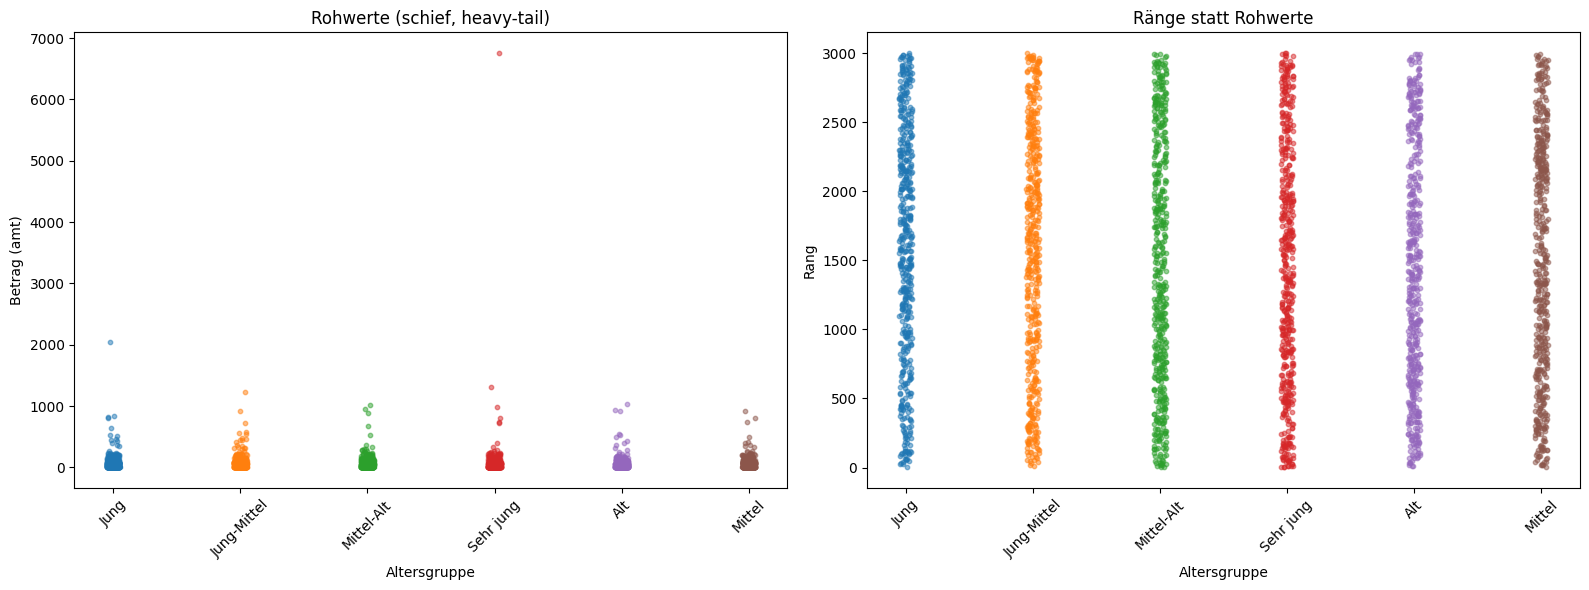

In [29]:
cats = ds["age_group6"].unique()
df_plot = ds.copy()

# Sampling Plot sieht sonst überladen aus
if len(df_plot) > 60000:
    df_plot = df_plot.groupby("age_group6").sample(500, replace=False, random_state=42)

df_plot["rank"] = df_plot["amt"].rank(method="average")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Links: Rohwerte
axes[0].set_title("Rohwerte (schief, heavy-tail)")
for i, cat in enumerate(cats):
    y = df_plot.loc[df_plot["age_group6"] == cat, "amt"]
    x = np.full_like(y, i, dtype=float) + (np.random.rand(len(y)) - 0.5)*0.1
    axes[0].scatter(x, y, alpha=0.5, s=10)
axes[0].set_xticks(range(len(cats)))
axes[0].set_xticklabels(cats, rotation=45)
axes[0].set_xlabel("Altersgruppe")
axes[0].set_ylabel("Betrag (amt)")

# Rechts: Ränge
axes[1].set_title("Ränge statt Rohwerte")
for i, cat in enumerate(cats):
    y = df_plot.loc[df_plot["age_group6"] == cat, "rank"]
    x = np.full_like(y, i, dtype=float) + (np.random.rand(len(y)) - 0.5)*0.1
    axes[1].scatter(x, y, alpha=0.5, s=10)
axes[1].set_xticks(range(len(cats)))
axes[1].set_xticklabels(cats, rotation=45)
axes[1].set_xlabel("Altersgruppe")
axes[1].set_ylabel("Rang")

plt.tight_layout()
plt.show()

Der obige Code erstellt eine zweigeteilte Visualisierung der Transaktionsbeträge nach Altersgruppen, um zu zeigen, warum ein Rangtest (Kruskal-Wallis) sinnvoll ist. Dafür werden bei großen Daten zuerst pro Altersgruppe 500 Beobachtungen gesampelt, links die rohen Beträge (stark schief mit Ausreißern) geplottet und rechts dieselben Daten als Ränge dargestellt, wodurch die Gruppen besser vergleichbar werden und Ausreißer weniger dominieren.

In [15]:
import scikit_posthocs as sp

raw_dunn_age = sp.posthoc_dunn(
    ds,
    val_col="amt",
    group_col="age_group6",
    p_adjust=None
)

raw_dunn_age

,Sehr jung,Jung,Jung-Mittel,Mittel,Mittel-Alt,Alt
Sehr jung,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Jung,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Jung-Mittel,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
Mittel,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Mittel-Alt,0.0000,0.0000,0.0000,0.0000,1.0000,0.4290
Alt,0.0000,0.0000,0.0000,0.0000,0.4290,1.0000


Erkenntnis:
Der Dunn-Post-hoc-Test zeigt, dass sich die Transaktionsbeträge zwischen fast allen Altersgruppen signifikant unterscheiden, mit Ausnahme der Gruppen „Mittel-Alt“ und „Alt“, zwischen denen kein signifikanter Unterschied besteht (p ≈ 0,43). Das bedeutet, dass sich die Beträge mit dem Alter systematisch verändern, dieser Effekt jedoch im höheren Altersbereich abflacht, sodass benachbarte ältere Gruppen statistisch ähnlich sind.

Hier wird die Multiple-Testing-Korrektur (FDR nach Benjamini–Hochberg) auf die paarweisen p-Werte aus dem Dunn-Test für die Altersgruppen angewendet und anschließend wieder als symmetrische Matrix aufgebaut.

In [16]:
from statsmodels.stats.multitest import multipletests

pvals = raw_dunn_age.values[np.triu_indices_from(raw_dunn_age, k=1)]

reject, pvals_corrected, _, _ = multipletests(
    pvals, alpha=0.05, method="fdr_bh"
)

groups = raw_dunn_age.columns
corr_age = pd.DataFrame(
    np.zeros_like(raw_dunn_age, dtype=float),
    index=groups,
    columns=groups
)

idx = 0
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        corr_age.iloc[i, j] = pvals_corrected[idx]
        corr_age.iloc[j, i] = pvals_corrected[idx]
        idx += 1

corr_age

,Sehr jung,Jung,Jung-Mittel,Mittel,Mittel-Alt,Alt
Sehr jung,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Jung,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Jung-Mittel,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mittel,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mittel-Alt,0.0000,0.0000,0.0000,0.0000,0.0000,0.4290
Alt,0.0000,0.0000,0.0000,0.0000,0.4290,0.0000


Erkenntnis aus der Matrix: Fast alle Vergleiche bleiben auch nach FDR signifikant (≈ 0.0000), außer „Mittel-Alt“ vs. „Alt“ (≈ 0.4290), d. h. diese beiden Altersgruppen unterscheiden sich im Betrag nicht statistisch relevant.

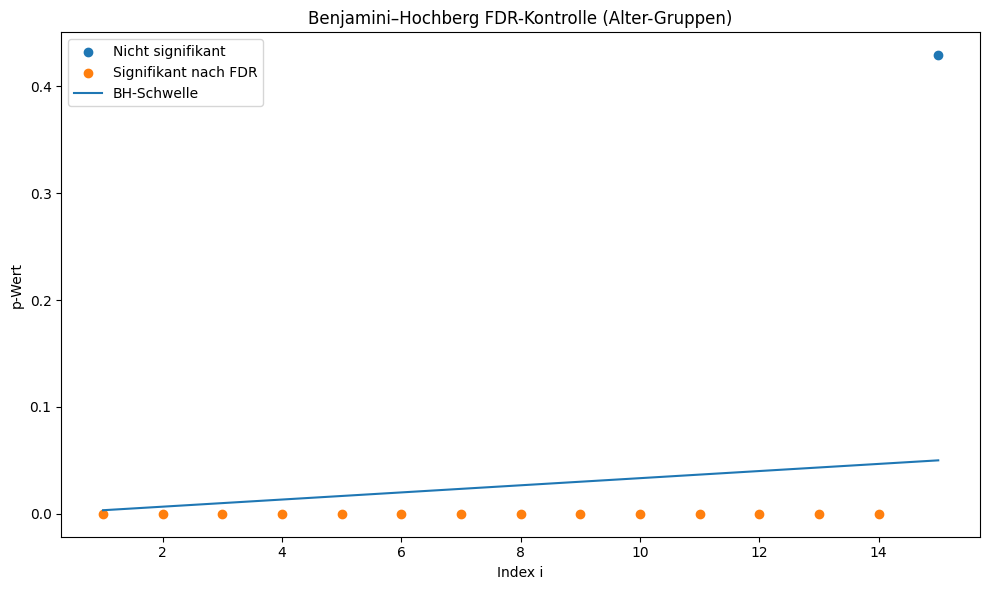

In [30]:
pvals = raw_dunn_age.values[np.triu_indices_from(raw_dunn_age, k=1)]
p_sorted = np.sort(pvals)
m = len(p_sorted)
alpha = 0.05
bh_thresholds = (np.arange(1, m+1)/m) * alpha

significant = p_sorted <= bh_thresholds

plt.figure(figsize=(10,6))
x = np.arange(1, m+1)

plt.scatter(x[~significant], p_sorted[~significant], label="Nicht signifikant")
plt.scatter(x[significant], p_sorted[significant], label="Signifikant nach FDR")
plt.plot(x, bh_thresholds, label="BH-Schwelle")

plt.xlabel("Index i")
plt.ylabel("p-Wert")
plt.title("Benjamini–Hochberg FDR-Kontrolle (Alter-Gruppen)")
plt.legend()
plt.tight_layout()
plt.show()

Erkenntnis:
Die Visualisierung zeigt, dass fast alle paarweisen Altersgruppenvergleiche auch nach Benjamini–Hochberg-Korrektur signifikant bleiben, da ihre p-Werte deutlich unter der BH-Schwelle liegen. Lediglich ein Vergleich liegt oberhalb der Schwelle (nicht signifikant), was bestätigt, dass die gefundenen Altersunterschiede robust sind und nicht durch multiples Testen künstlich entstanden sind.

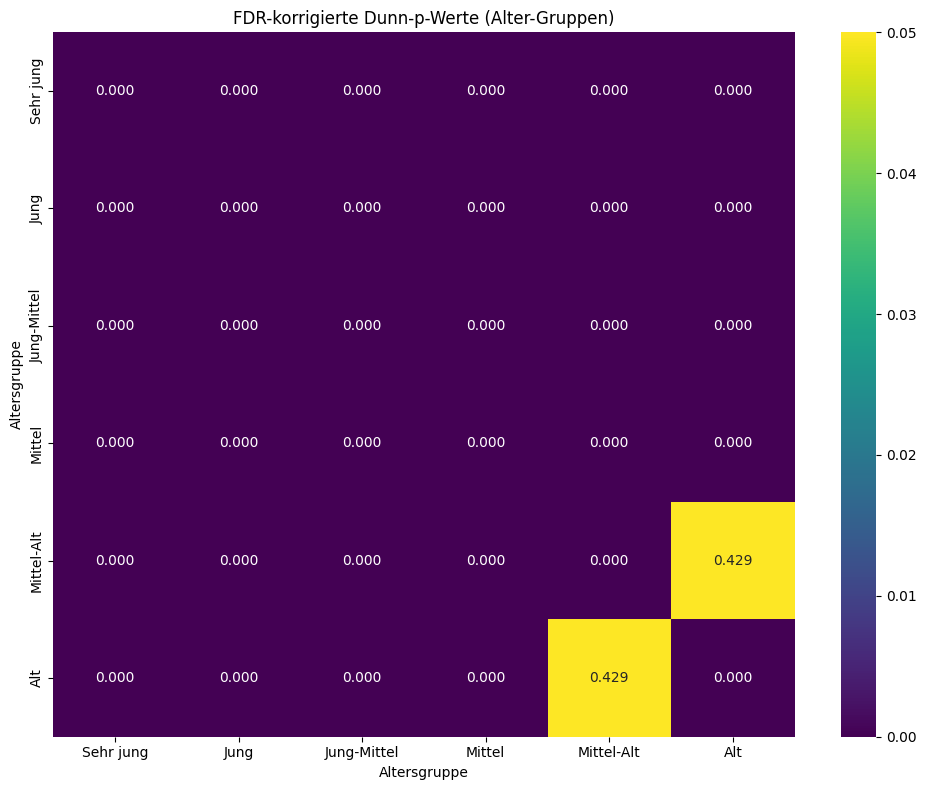

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_age, cmap="viridis", vmin=0, vmax=0.05, annot=True, fmt=".3f")
plt.title("FDR-korrigierte Dunn-p-Werte (Alter-Gruppen)")
plt.xlabel("Altersgruppe")
plt.ylabel("Altersgruppe")
plt.tight_layout()
plt.show()

Erkenntnis:
Die Heatmap zeigt, dass nach FDR-Korrektur nahezu alle Altersgruppenpaare signifikant unterschiedliche Transaktionsbeträge aufweisen, was die Robustheit des Alterseffekts bestätigt. Einzig die Altersgruppen „Mittel-Alt“ und „Alt“ unterscheiden sich nicht signifikant, was darauf hindeutet, dass sich das Ausgabeverhalten im höheren Alter stabilisiert und keine weiteren relevanten Unterschiede mehr auftreten.

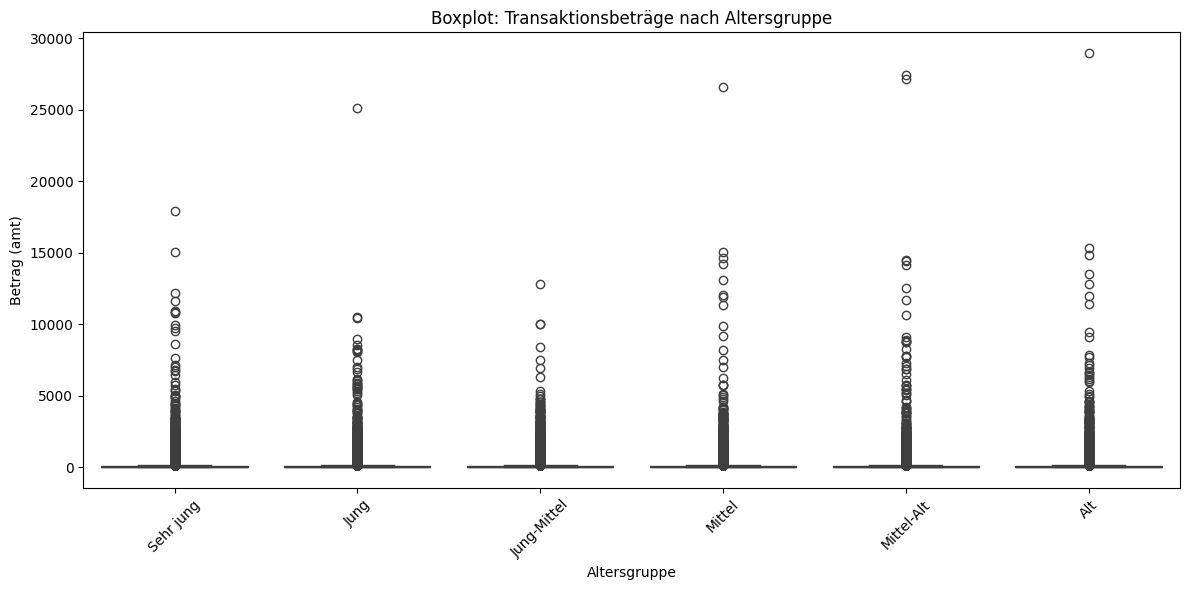

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=ds, x="age_group6", y="amt")
plt.xticks(rotation=45)
plt.title("Boxplot: Transaktionsbeträge nach Altersgruppe")
plt.xlabel("Altersgruppe")
plt.ylabel("Betrag (amt)")
plt.tight_layout()
plt.show()

Erkenntnis:
Der Boxplot zeigt, dass die Transaktionsbeträge in allen Altersgruppen stark rechtsschief verteilt sind und von vielen Ausreißern dominiert werden, während sich die Mediane zwischen den Gruppen nur moderat unterscheiden. Gleichzeitig ist erkennbar, dass mit zunehmendem Alter tendenziell höhere und variablere Beträge auftreten, was die zuvor gefundenen signifikanten Unterschiede bestätigt, jedoch auch verdeutlicht, warum nichtparametrische Tests erforderlich sind.

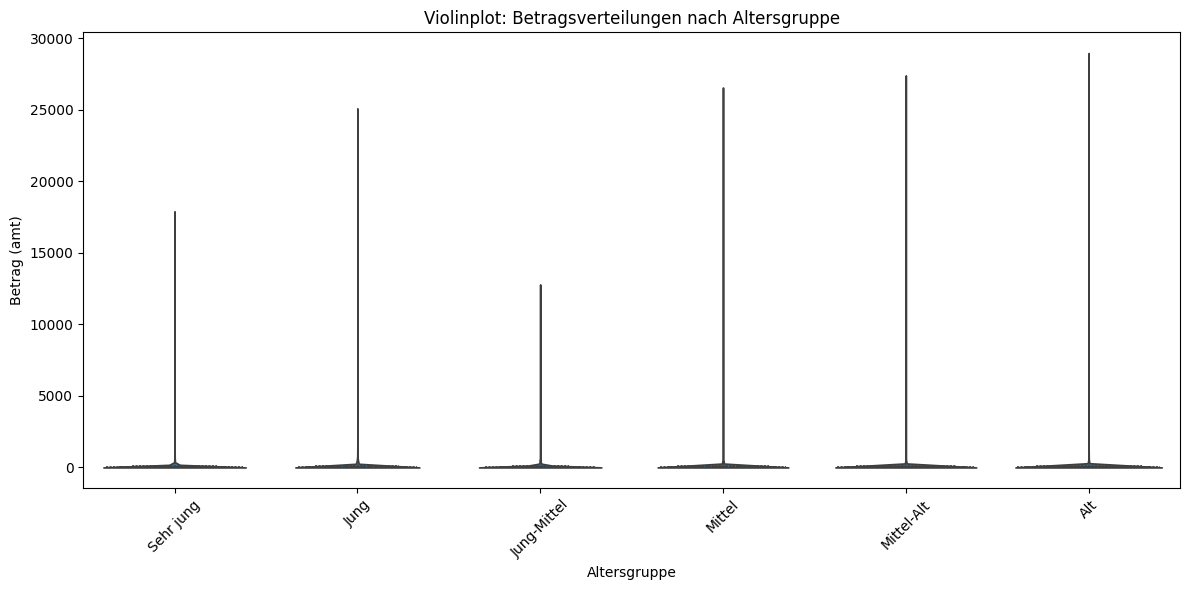

In [19]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=ds, x="age_group6", y="amt", cut=0, inner="quartile")
plt.xticks(rotation=45)
plt.title("Violinplot: Betragsverteilungen nach Altersgruppe")
plt.xlabel("Altersgruppe")
plt.ylabel("Betrag (amt)")
plt.tight_layout()
plt.show()

Erkenntnis:
Der Violinplot macht deutlich, dass die Transaktionsbeträge in allen Altersgruppen stark rechtsschief und heavy-tailed sind, wobei sich die Hauptdichte auf niedrige Beträge konzentriert und wenige sehr hohe Ausreißer auftreten. Mit zunehmendem Alter wird die Verteilung tendenziell breiter und nach oben ausgeprägter, was die signifikanten Altersunterschiede bestätigt und zugleich zeigt, dass Mittelwerte allein wenig aussagekräftig sind.

/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_79577/3648120886.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = ds.groupby("age_group6")["amt"].agg(["median", "mean"]).reset_index()


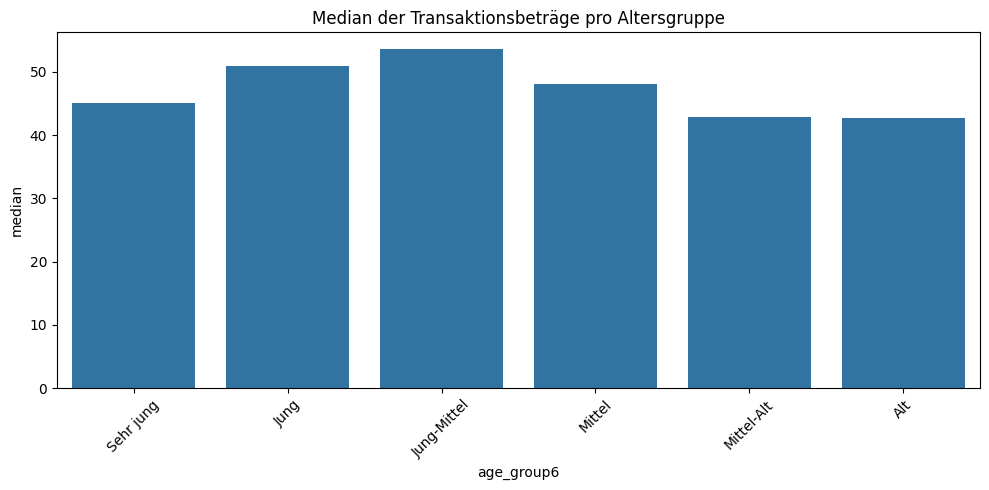

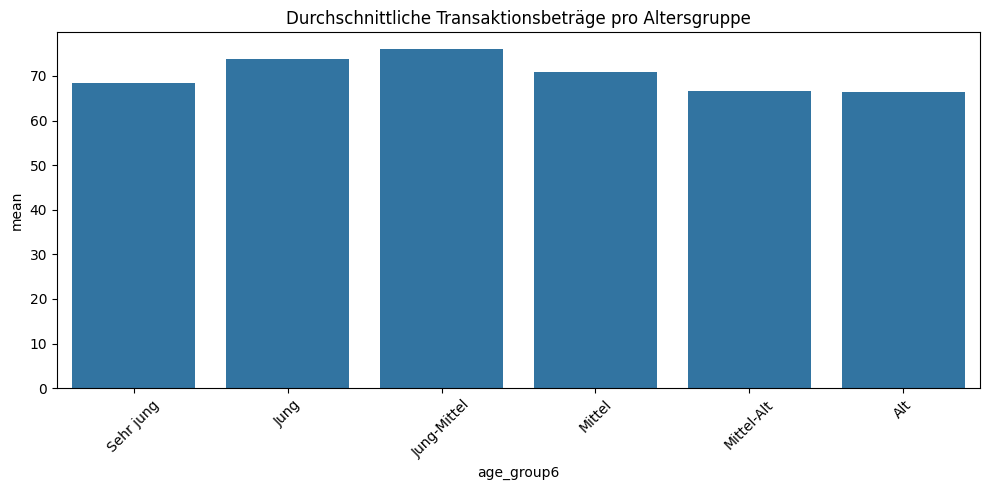

In [22]:
summary = ds.groupby("age_group6")["amt"].agg(["median", "mean"]).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=summary, x="age_group6", y="median")
plt.xticks(rotation=45)
plt.title("Median der Transaktionsbeträge pro Altersgruppe")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=summary, x="age_group6", y="mean")
plt.xticks(rotation=45)
plt.title("Durchschnittliche Transaktionsbeträge pro Altersgruppe")
plt.tight_layout()
plt.show()

Erkenntnis:
Die Balkendiagramme zeigen, dass Median und Mittelwert der Transaktionsbeträge mit zunehmendem Alter zunächst ansteigen und in der mittleren Altersgruppe ihren Höhepunkt erreichen, bevor sie in den höheren Altersgruppen wieder leicht abnehmen. Der Abstand zwischen Mittelwert und Median verdeutlicht zugleich die starke Rechtsschiefe der Beträge, weshalb der Median die robustere Kennzahl für den typischen Transaktionsbetrag darstellt.

Der folgende Code vergleicht alle Altersgruppen paarweise und erstellt eine Tabelle, die für jedes Gruppenpaar sowohl statistische Signifikanz als auch praktische Relevanz zusammenfasst. Dafür nimmt er die FDR-korrigierten p-Werte aus corr_age, berechnet die Mittelwerte der Beträge pro Altersgruppe, die Mittelwertdifferenz und zusätzlich Cliff’s Delta (inkl. Effektstärken-Kategorie) als robustes Effektmaß für zwei Verteilungen. Am Ende werden die Ergebnisse in einem DataFrame gesammelt und nach der Stärke des Effekts (|Delta|) sortiert ausgegeben.

In [23]:
from cliffs_delta import cliffs_delta

# Mittelwerte pro Altersgruppe
group_means = ds.groupby("age_group6")["amt"].mean()

# Alle Paarvergleiche sammeln (inkl. FDR-p-Werte)
rows = []

groups = corr_age.index.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1 = groups[i]
        g2 = groups[j]

        # FDR-korrigierter p-Wert
        p = corr_age.loc[g1, g2]

        # Daten der Gruppen
        x = ds[ds["age_group6"] == g1]["amt"]
        y = ds[ds["age_group6"] == g2]["amt"]

        # Mittelwerte
        m1 = group_means[g1]
        m2 = group_means[g2]
        diff = m2 - m1

        # Cliff's Delta
        delta, size = cliffs_delta(x, y)

        rows.append({
            "Gruppe 1": g1,
            "Gruppe 2": g2,
            "MW Gruppe 1": m1,
            "MW Gruppe 2": m2,
            "Differenz (G2 - G1)": diff,
            "p-Wert (FDR)": p,
            "Cliff's Delta": delta,
            "Effekt-Kategorie": size
        })


# DataFrame bauen
age_compare_cliff = pd.DataFrame(rows)

# p-Werte schön formatieren
age_compare_cliff["p-Wert (FDR)"] = age_compare_cliff["p-Wert (FDR)"].apply(lambda x: format(x, ".12e"))

# Nach Effektstärke sortieren (nach |Cliff’s Delta|)
age_compare_cliff = age_compare_cliff.reindex(
    age_compare_cliff["Cliff's Delta"].abs().sort_values().index
)

# Anzeige normal zurücksetzen
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.expand_frame_repr")

age_compare_cliff

/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_79577/3582084104.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = ds.groupby("age_group6")["amt"].mean()


,Gruppe 1,Gruppe 2,MW Gruppe 1,MW Gruppe 2,Differenz (G2 - G1),p-Wert (FDR),Cliff's Delta,Effekt-Kategorie
14,Mittel-Alt,Alt,66.5292,66.4633,-0.0659,4.289737263750e-01,0.0014,negligible
3,Sehr jung,Mittel-Alt,68.4148,66.5292,-1.8856,2.214920396007e-06,0.0090,negligible
4,Sehr jung,Alt,68.4148,66.4633,-1.9515,3.553305416795e-08,0.0104,negligible
6,Jung,Mittel,73.7837,70.9552,-2.8286,1.508266687755e-55,0.0276,negligible
5,Jung,Jung-Mittel,73.7837,75.9766,2.1929,2.215031291250e-60,-0.0290,negligible
2,Sehr jung,Mittel,68.4148,70.9552,2.5404,3.705969979420e-66,-0.0303,negligible
12,Mittel,Mittel-Alt,70.9552,66.5292,-4.4259,3.936005301903e-106,0.0384,negligible
13,Mittel,Alt,70.9552,66.4633,-4.4919,1.215377681314e-113,0.0398,negligible
9,Jung-Mittel,Mittel,75.9766,70.9552,-5.0215,5.733726065006e-227,0.0566,negligible
0,Sehr jung,Jung,68.4148,73.7837,5.3689,1.518068673927e-236,-0.0582,negligible


Erkenntnis:
Obwohl viele Altersgruppenvergleiche aufgrund der sehr großen Stichprobe hochsignifikante p-Werte aufweisen, zeigen die Cliff’s-Delta-Werte durchweg nur vernachlässigbare Effektstärken. Das bedeutet, dass sich die Transaktionsbeträge zwischen den Altersgruppen zwar statistisch unterscheiden, diese Unterschiede jedoch praktisch kaum relevant sind; das Alter hat also nur einen sehr schwachen Einfluss auf die Höhe einzelner Transaktionen.

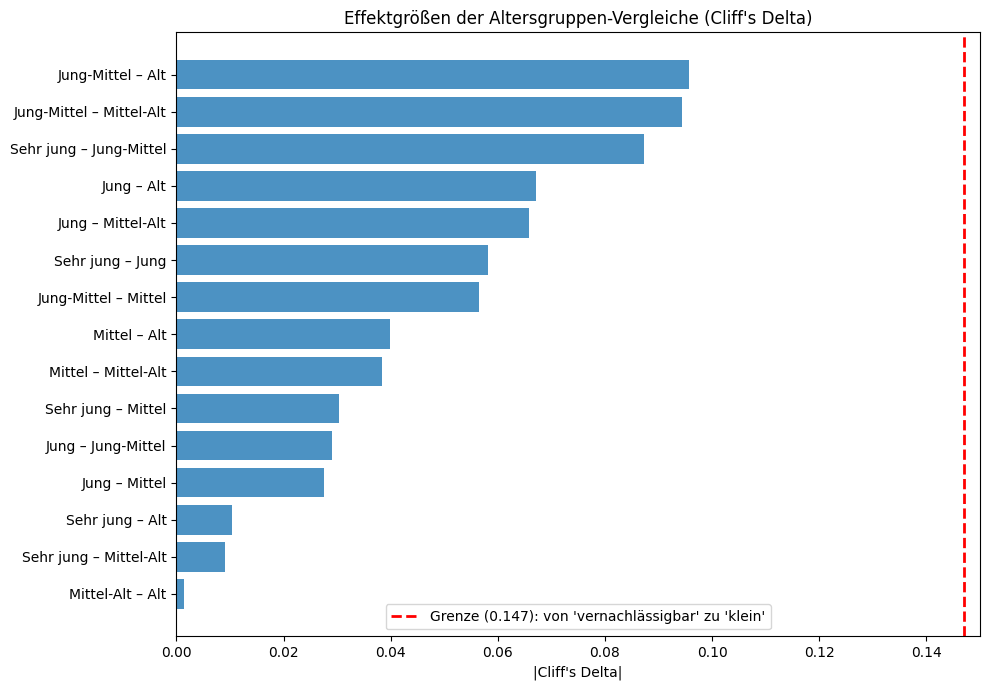

In [32]:

# Paar-Labels und |Cliff's Delta| berechnen
plot_df = age_compare_cliff.copy()
plot_df["Paar"] = plot_df["Gruppe 1"].astype(str) + " – " + plot_df["Gruppe 2"].astype(str)
plot_df["abs_delta"] = plot_df["Cliff's Delta"].abs()

# Nach Effektstärke sortieren
plot_df = plot_df.sort_values("abs_delta")

# Plot
plt.figure(figsize=(10, 7))
y_pos = np.arange(len(plot_df))

plt.barh(y_pos, plot_df["abs_delta"], color="tab:blue", alpha=0.8)
plt.yticks(y_pos, plot_df["Paar"])
plt.xlabel("|Cliff's Delta|")
plt.title("Effektgrößen der Altersgruppen-Vergleiche (Cliff's Delta)")

# Schwelle zwischen 'negligible' und 'small' einzeichnen
threshold = 0.147
plt.axvline(threshold, color="red", linestyle="--", linewidth=2, label="Grenze (0.147): von 'vernachlässigbar' zu 'klein'")

# x-Achse auf einen sinnvollen Bereich beschränken (hier bis 0.15, weil alle Effekte klein sind)
plt.xlim(0, 0.15)

plt.legend()
plt.tight_layout()
plt.show()

Erkenntnis:
Der Plot zeigt, dass alle Effektstärken der Altersgruppenvergleiche deutlich unter der Schwelle von 0,147 liegen, die den Übergang von „vernachlässigbar“ zu „klein“ markiert. Damit wird klar, dass sich die Transaktionsbeträge zwar statistisch signifikant zwischen Altersgruppen unterscheiden, die praktische Bedeutung dieser Unterschiede jedoch durchweg sehr gering ist, selbst bei den stärksten beobachteten Alterskontrasten.